<a href="https://colab.research.google.com/github/twooverzero/Anomaly-Detection-and-Prognostics-MSCRED/blob/master/MSCRED_for_Regasification_Unit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install heatmapz
!pip install ipython-autotime

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 7,7 
import seaborn as sns
sns.set(color_codes=True, font_scale=1.2)
%load_ext autotime

import os
import re

tf.test.gpu_device_name()
!nvidia-smi
print(tf.__version__)

TensorFlow 1.x selected.
Tue Jan 19 14:40:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W /  70W |    111MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                               

In [ ]:
# Import the two methods from heatmap library
from heatmap import heatmap, corrplot

time: 3.04 ms (started: 2021-01-19 14:40:57 +00:00)


딥러닝 코드 시작하는 부분
hyper parameter

In [ ]:
# Parameter initialization

gap_time = 10  # gap time between each segment
win_size = [10, 30, 60]  # window size of each segment
step_max = 5 # maximum step of ConvLSTM

# make data path directory
if not os.path.exists("../content/data/"):
    os.makedirs("../content/data/")

# setting raw data path
raw_data_path = '../content/data/FSRU_Trial_Pump_concat_on_normalied.csv'  # path to load raw data
valid_data_path = '../content/data/FSRU_Trial_Pump_validation.csv'

model_path = '../content/MSCRED/'
train_data_path = "../content/data/train/"
test_data_path = "../content/data/test/"
valid_data_path = "../content/data/valid/"

reconstructed_data_path = "../content/data/reconstructed/"


train_start_id = 60 # maximum window size matters
train_end_id = 200

test_start_id = 201
test_end_id = 400

valid_start_id = 400
valid_end_id = 450

training_iters = 5
save_model_step = 1

learning_rate = 0.002

threhold = 0.005
alpha = 1.5

time: 9.43 ms (started: 2021-01-19 14:42:37 +00:00)


In [ ]:
class CorrelationMatrices:
    def __init__(self):

        scaler = MinMaxScaler(feature_range=(0, 1))
        self.raw_data = scaler.fit_transform(pd.read_csv(raw_data_path, header=None).T)
        self.series_number = self.raw_data.shape[0]
        self.series_length = self.raw_data.shape[1]
        self.signature_matrices_number = int(self.series_length / gap_time)

        print("series_number is", self.series_number)
        print("series_length is", self.series_length)
        print("signature_matrices_number is", self.signature_matrices_number)

    def correlation_matrices_generation(self, win):
      
        if win == 0:
            print("The size of win cannot be 0")

        raw_data = np.asarray(self.raw_data)
        correlation_matrices = np.zeros((self.signature_matrices_number, self.series_number, self.series_number))

        for t in range(win, self.signature_matrices_number):
            raw_data_t = raw_data[:, t - win:t]
            correlation_matrices[t] = np.corrcoef(raw_data_t)
          
        return correlation_matrices

        
    def generate_train_test(self, signature_matrices):
        """
        Generate train and test dataset, and store them to ../data/train/train.npy and ../data/test/test.npy
        :param signature_matrices:
        :return:
        """
        train_dataset = []
        test_dataset = []

        for data_id in range(self.signature_matrices_number):
            index = data_id - step_max + 1
            if data_id < train_start_id:
                continue
            index_dataset = signature_matrices[:, index:index + step_max]
            if data_id < test_start_id:
                train_dataset.append(index_dataset)
            else:
                test_dataset.append(index_dataset)

        train_dataset = np.asarray(train_dataset)
        train_dataset = np.reshape(train_dataset, [-1, step_max, self.series_number, self.series_number,
                                                   signature_matrices.shape[0]])
        test_dataset = np.asarray(test_dataset)
        test_dataset = np.reshape(test_dataset, [-1, step_max,self.series_number, self.series_number,
                                                signature_matrices.shape[0]])

        print("train dataset shape is", train_dataset.shape)
        print("test dataset shape is", test_dataset.shape)

        train_path = "../content/data/train/"
        if not os.path.exists(train_path):
            os.makedirs(train_path)
        train_path = train_path + "train.npy"

        test_path = "../content/data/test/"
        if not os.path.exists(test_path):
            os.makedirs(test_path)
        test_path = test_path + "test.npy"

        np.save(train_path, train_dataset)
        np.save(test_path, test_dataset)

        #print("Example train matrix : ", train_dataset[300,0,:,:,0])
        #print("Example test matrix : ", test_dataset[1250,0,:,:,0])
        #np.savetxt(train_path, train_dataset[300,0,:,:,0])
        #np.savetxt(test_path, test_dataset[1250,0,:,:,0])


if __name__ == '__main__':
    Matrices_C = CorrelationMatrices()
    correlation_matrices = []

    # Generation signature matrices according the win size w
    for w in win_size:
        correlation_matrices.append(Matrices_C.correlation_matrices_generation(w))

    correlation_matrices = np.asarray(correlation_matrices)
    print("the shape of correlation_matrices is", correlation_matrices.shape)

    # Generate train and test dataset
    Matrices_C.generate_train_test(correlation_matrices)

series_number is 10
series_length is 4617
signature_matrices_number is 461


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


the shape of correlation_matrices is (3, 461, 10, 10)
train dataset shape is (191, 5, 10, 10, 3)
test dataset shape is (260, 5, 10, 10, 3)
time: 367 ms (started: 2021-01-19 14:42:40 +00:00)


In [ ]:
"""
To represent the inter-correlations between different pairs of time series om a multivariate
time  series segment from t-w to t, we construct an n * n signature matrix M based upon the
pairwise inner-product of two time series within the segment.
Construct s (s = 3) signature matrices with different lengths(w = 10, 30, 60)
"""

class SignatureMatrices:
    def __init__(self):

        scaler = MinMaxScaler(feature_range=(0, 1))
        self.raw_data = scaler.fit_transform(pd.read_csv(raw_data_path, header=None).T)
        self.series_number = self.raw_data.shape[0]
        self.series_length = self.raw_data.shape[1]
        self.signature_matrices_number = int(self.series_length / gap_time)

        print("series_number is", self.series_number)
        print("series_length is", self.series_length)
        print("signature_matrices_number is", self.signature_matrices_number)

    def signature_matrices_generation(self, win):
        """
        Generation signature matrices according win_size and gap_time, the size of raw_data is n * T, n is the number of
        time series, T is the length of time series.
        To represent the inter-correlations between different pairs of time series in a multivariate time series segment
        from t − w to t, we construct an n × n signature matrix Mt based upon the pairwise inner-product of two time series
        within this segment.
        :param win: the length of the time series segment
        :return: the signature matrices
        """

        if win == 0:
            print("The size of win cannot be 0")

        raw_data = np.asarray(self.raw_data)
        signature_matrices = np.zeros((self.signature_matrices_number, self.series_number, self.series_number))

        for t in range(win, self.signature_matrices_number):
            raw_data_t = raw_data[:, t - win:t]
            signature_matrices[t] = np.dot(raw_data_t, raw_data_t.T) / win
            
        return signature_matrices

    def generate_train_test(self, signature_matrices):
        """
        Generate train and test dataset, and store them to ../data/train/train.npy and ../data/test/test.npy
        :param signature_matrices:
        :return:
        """
        train_dataset = []
        test_dataset = []

        for data_id in range(self.signature_matrices_number):
            index = data_id - step_max + 1
            if data_id < train_start_id:
                continue
            index_dataset = signature_matrices[:, index:index + step_max]
            if data_id < test_start_id:
                train_dataset.append(index_dataset)
            else:
                test_dataset.append(index_dataset)

        train_dataset = np.asarray(train_dataset)
        train_dataset = np.reshape(train_dataset, [-1, step_max, self.series_number, self.series_number,
                                                   signature_matrices.shape[0]])
        test_dataset = np.asarray(test_dataset)
        test_dataset = np.reshape(test_dataset, [-1, step_max,self.series_number, self.series_number,
                                                signature_matrices.shape[0]])

        print("train dataset shape is", train_dataset.shape)
        print("test dataset shape is", test_dataset.shape)

        train_path = "../content/data/train/"
        if not os.path.exists(train_path):
            os.makedirs(train_path)
        train_path = train_path + "train.npy"

        test_path = "../content/data/test/"
        if not os.path.exists(test_path):
            os.makedirs(test_path)
        test_path = test_path + "test.npy"

        np.save(train_path, train_dataset)
        np.save(test_path, test_dataset)

        #print("Example train matrix : ", train_dataset[300,0,:,:,0])
        #print("Example test matrix : ", test_dataset[1250,0,:,:,0])
        #np.savetxt(train_path, train_dataset[300,0,:,:,0])
        #np.savetxt(test_path, test_dataset[1250,0,:,:,0])


if __name__ == '__main__':
    Matrices = SignatureMatrices()
    signature_matrices = []

    # Generation signature matrices according the win size w
    for w in win_size:
        signature_matrices.append(Matrices.signature_matrices_generation(w))

    signature_matrices = np.asarray(signature_matrices)
    print("the shape of signature_matrices is", signature_matrices.shape)

    # Generate train and test dataset
    Matrices.generate_train_test(signature_matrices)

series_number is 10
series_length is 4617
signature_matrices_number is 461
the shape of signature_matrices is (3, 461, 10, 10)
train dataset shape is (191, 5, 10, 10, 3)
test dataset shape is (260, 5, 10, 10, 3)
time: 118 ms (started: 2021-01-19 14:42:47 +00:00)


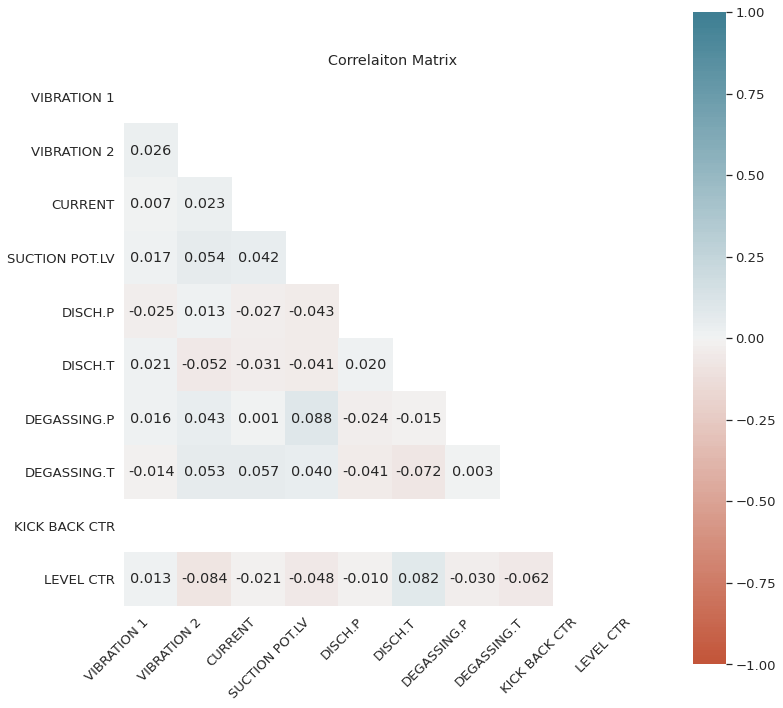

time: 490 ms (started: 2021-01-19 14:56:08 +00:00)


In [ ]:
axis_labels = ['VIBRATION 1', 'VIBRATION 2', 'CURRENT','SUCTION POT.LV','DISCH.P', 'DISCH.T', 'DEGASSING.P', 'DEGASSING.T', 'KICK BACK CTR','LEVEL CTR'] # labels for axis

mask = np.zeros_like(correlation_matrices[0,300,:,:])
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
  f, ax = plt.subplots(figsize=(12, 12))
  ax = sns.heatmap(correlation_matrices[0,300,:,:],vmin=-1, vmax=1, center=0,annot=True, fmt=".3f", mask=mask, cmap=sns.diverging_palette(20,220,n=200),square=True,xticklabels=axis_labels, yticklabels=axis_labels)
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right');
  ax.set_title('Correlaiton Matrix');

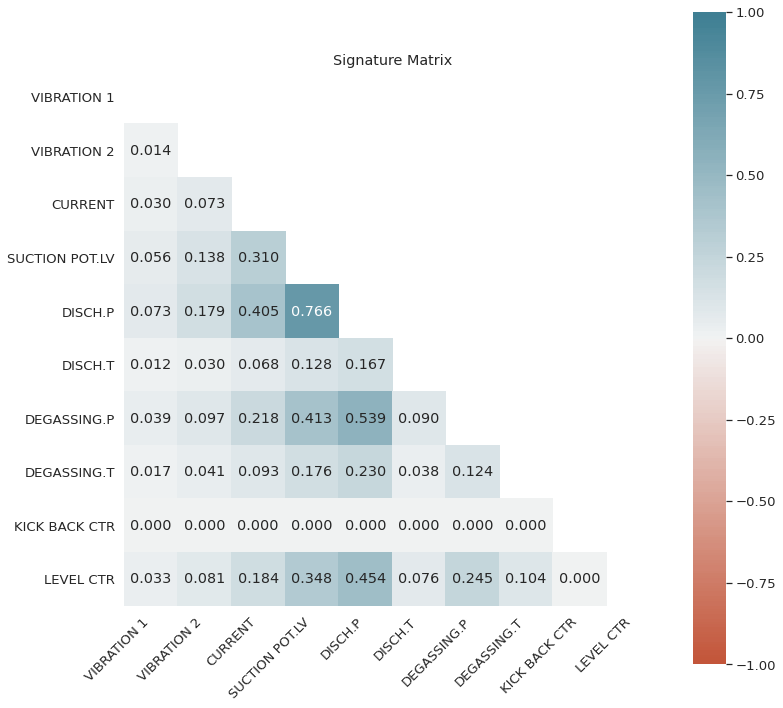

time: 504 ms (started: 2021-01-19 14:56:32 +00:00)


In [ ]:
axis_labels = ['VIBRATION 1', 'VIBRATION 2', 'CURRENT','SUCTION POT.LV','DISCH.P', 'DISCH.T', 'DEGASSING.P', 'DEGASSING.T', 'KICK BACK CTR','LEVEL CTR'] # labels for axis

mask = np.zeros_like(signature_matrices[0,300,:,:])
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
  f, ax = plt.subplots(figsize=(12, 12))
  ax = sns.heatmap(signature_matrices[0,300,:,:],vmin=-1, vmax=1, center=0,annot=True, fmt=".3f", mask=mask, cmap=sns.diverging_palette(20,220,n=200),square=True,xticklabels=axis_labels, yticklabels=axis_labels)
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right');
  ax.set_title('Signature Matrix');

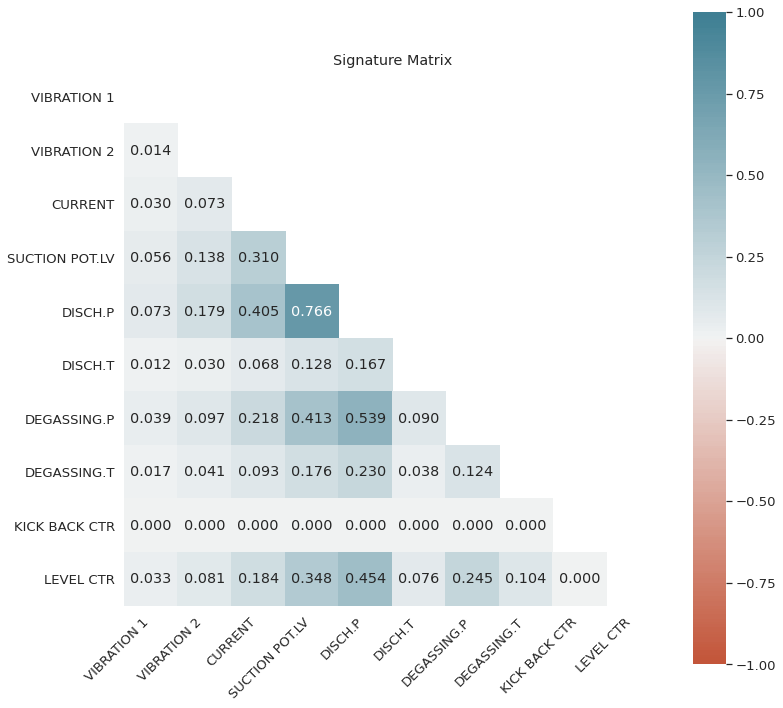

time: 566 ms (started: 2021-01-19 15:01:20 +00:00)


In [ ]:
axis_labels = ['VIBRATION 1', 'VIBRATION 2', 'CURRENT','SUCTION POT.LV','DISCH.P', 'DISCH.T', 'DEGASSING.P', 'DEGASSING.T', 'KICK BACK CTR','LEVEL CTR'] # labels for axis

mask = np.zeros_like(signature_matrices[2,300,:,:])
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
  f, ax = plt.subplots(figsize=(12, 12))
  ax = sns.heatmap(signature_matrices[0,300,:,:],vmin=-1, vmax=1, center=0,annot=True, fmt=".3f", mask=mask, cmap=sns.diverging_palette(20,220,n=200),square=True,xticklabels=axis_labels, yticklabels=axis_labels)
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right');
  ax.set_title('Signature Matrix');

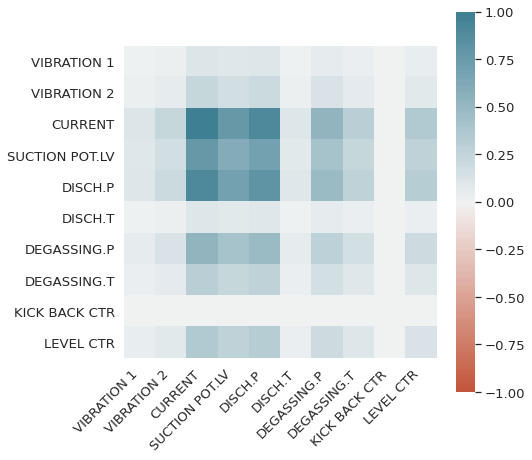

time: 301 ms (started: 2021-01-19 15:01:38 +00:00)


In [ ]:
axis_labels = ['VIBRATION 1', 'VIBRATION 2', 'CURRENT','SUCTION POT.LV','DISCH.P', 'DISCH.T', 'DEGASSING.P', 'DEGASSING.T', 'KICK BACK CTR','LEVEL CTR'] # labels for axis

ax = sns.heatmap(signature_matrices[0,100,:,:],vmin=-1, vmax=1, center=0,cmap=sns.diverging_palette(20,220,n=200),square=True,xticklabels=axis_labels, yticklabels=axis_labels)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right');

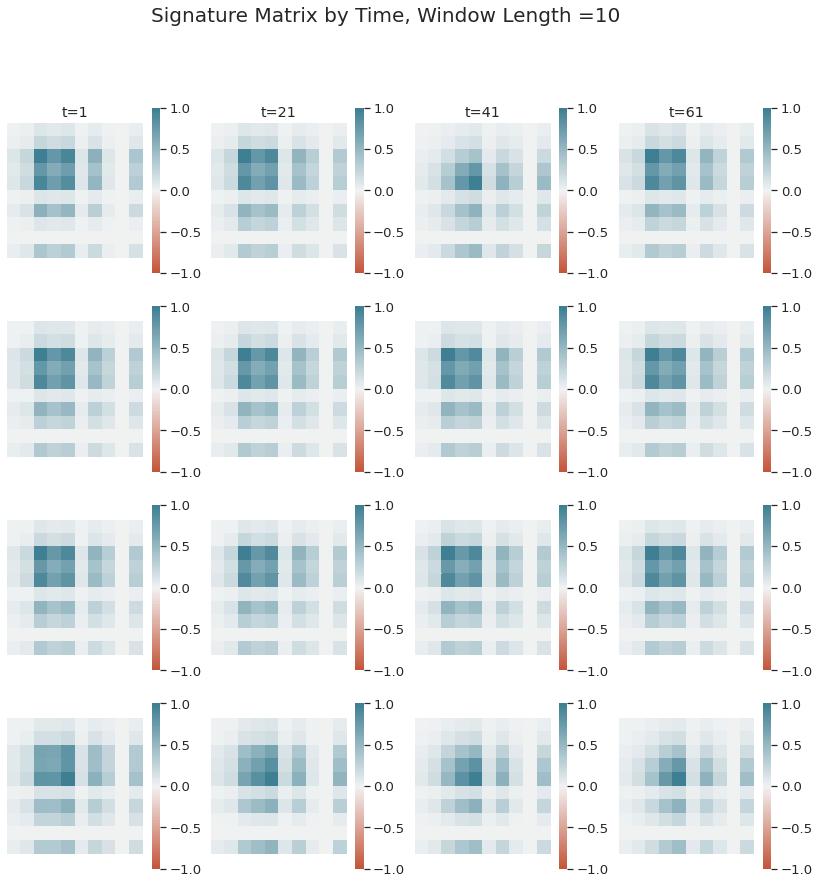

In [ ]:
fig = plt.figure(figsize=[14,14])
fig.suptitle('Signature Matrix by Time, Window Length =10', fontsize=20)

ax1=fig.add_subplot(4,4,1)
ax2=fig.add_subplot(4,4,2)
ax3=fig.add_subplot(4,4,3)
ax4=fig.add_subplot(4,4,4)
ax5=fig.add_subplot(4,4,5)
ax6=fig.add_subplot(4,4,6)
ax7=fig.add_subplot(4,4,7)
ax8=fig.add_subplot(4,4,8)
ax9=fig.add_subplot(4,4,9)
ax10=fig.add_subplot(4,4,10)
ax11=fig.add_subplot(4,4,11)
ax12=fig.add_subplot(4,4,12)
ax13=fig.add_subplot(4,4,13)
ax14=fig.add_subplot(4,4,14)
ax15=fig.add_subplot(4,4,15)
ax16=fig.add_subplot(4,4,16)

sns.heatmap(signature_matrices[0,10,:,:],vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax1)
ax1.set_title('t=1')
sns.heatmap(signature_matrices[0,20,:,:],vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax2)
ax2.set_title('t=21')
sns.heatmap(signature_matrices[0,30,:,:],vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax3)
ax3.set_title('t=41')
sns.heatmap(signature_matrices[0,40,:,:],vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax4)
ax4.set_title('t=61')
sns.heatmap(signature_matrices[0,50,:,:],vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax5)
ax5.set_title('t=810')
sns.heatmap(signature_matrices[0,60,:,:],vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax6)
ax6.set_title('t=1010')
sns.heatmap(signature_matrices[0,70,:,:],vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax7)
ax7.set_title('t=1210')
sns.heatmap(signature_matrices[0,80,:,:],vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax8)
ax8.set_title('t=1410')
sns.heatmap(signature_matrices[0,161,:,:],vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax9)
ax9.set_title('t=1610')
sns.heatmap(signature_matrices[0,181,:,:],vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax10)
ax10.set_title('t=1810')
sns.heatmap(signature_matrices[0,201,:,:],vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax11)
ax11.set_title('t=2010')
sns.heatmap(signature_matrices[0,222,:,:],vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax12)
ax12.set_title('t=2210')
sns.heatmap(signature_matrices[0,241,:,:],vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax13)
ax13.set_title('t=2410')
sns.heatmap(signature_matrices[0,261,:,:],vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax14)
ax14.set_title('t=2610')
sns.heatmap(signature_matrices[0,281,:,:],vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax15)
ax15.set_title('t=2810')
sns.heatmap(signature_matrices[0,301,:,:],vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200),xticklabels=False, yticklabels=False,square=True, ax=ax16)
ax16.set_title('t=3010')

plt.show()

Correlation Matrix

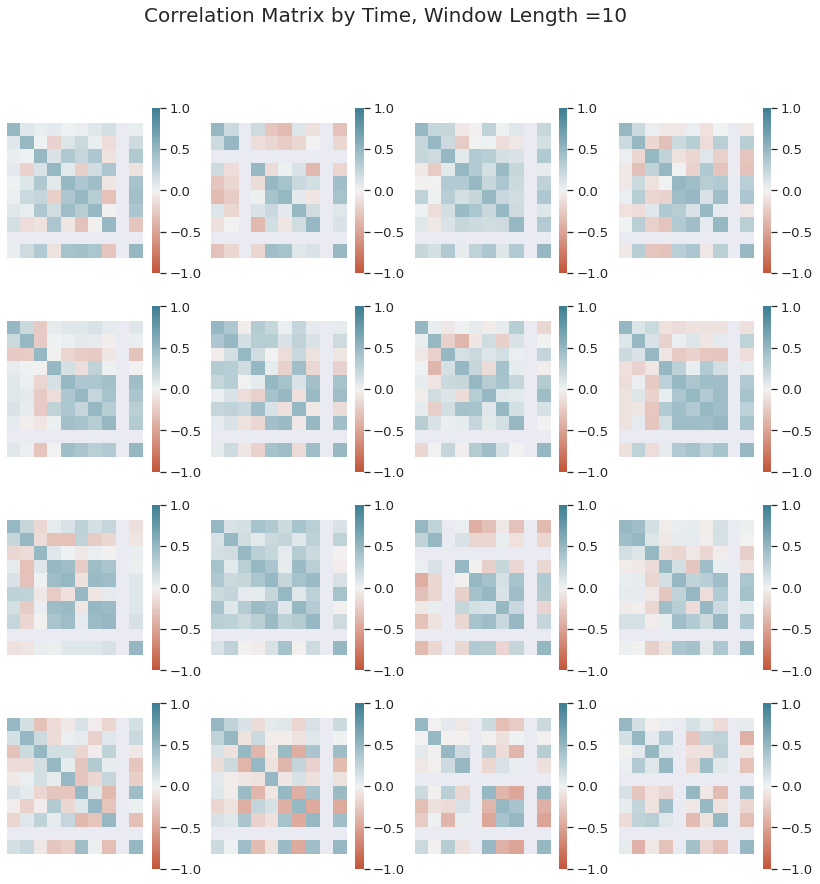

time: 7.59 s (started: 2021-01-19 00:40:50 +00:00)


In [ ]:
fig = plt.figure(figsize=[14,14])
fig.suptitle('Correlation Matrix by Time, Window Length =10', fontsize=20)

multiplier =5 
ax1=fig.add_subplot(4,4,1)
ax2=fig.add_subplot(4,4,2)
ax3=fig.add_subplot(4,4,3)
ax4=fig.add_subplot(4,4,4)
ax5=fig.add_subplot(4,4,5)
ax6=fig.add_subplot(4,4,6)
ax7=fig.add_subplot(4,4,7)
ax8=fig.add_subplot(4,4,8)
ax9=fig.add_subplot(4,4,9)
ax10=fig.add_subplot(4,4,10)
ax11=fig.add_subplot(4,4,11)
ax12=fig.add_subplot(4,4,12)
ax13=fig.add_subplot(4,4,13)
ax14=fig.add_subplot(4,4,14)
ax15=fig.add_subplot(4,4,15)
ax16=fig.add_subplot(4,4,16)

sns.heatmap(np.dot(multiplier,correlation_matrices[0,11,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax1)
ax1.set_title='t=10'
sns.heatmap(np.dot(multiplier,correlation_matrices[0,21,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax2)
ax2.set_title='t=210'
sns.heatmap(np.dot(multiplier,correlation_matrices[0,41,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax3)
ax3.set_title='t=410'
sns.heatmap(np.dot(multiplier,correlation_matrices[0,61,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax4)
ax4.set_title='t=610'
sns.heatmap(np.dot(multiplier,correlation_matrices[0,81,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax5)
ax5.set_title='t=810'
sns.heatmap(np.dot(multiplier,correlation_matrices[0,101,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax6)
ax6.set_title='t=1010'
sns.heatmap(np.dot(multiplier,correlation_matrices[0,121,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax7)
ax7.set_title='t=1210'
sns.heatmap(np.dot(multiplier,correlation_matrices[0,141,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax8)
ax8.set_title='t=1410'
sns.heatmap(np.dot(multiplier,correlation_matrices[0,161,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax9)
ax9.set_title='t=1610'
sns.heatmap(np.dot(multiplier,correlation_matrices[0,181,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax10)
ax10.set_title='t=1810'
sns.heatmap(np.dot(multiplier,correlation_matrices[0,201,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax11)
ax11.set_title='t=2010'
sns.heatmap(np.dot(multiplier,correlation_matrices[0,222,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax12)
ax12.set_title='t=2210'
sns.heatmap(np.dot(multiplier,correlation_matrices[0,241,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax13)
ax13.set_title='t=2410'
sns.heatmap(np.dot(multiplier,correlation_matrices[0,261,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax14)
ax14.set_title='t=2610'
sns.heatmap(np.dot(multiplier,correlation_matrices[0,281,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax15)
ax15.set_title='t=2810'
sns.heatmap(np.dot(multiplier,correlation_matrices[0,301,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200),xticklabels=False, yticklabels=False,square=True, ax=ax16)
ax16.set_title='t=3010'

plt.show()

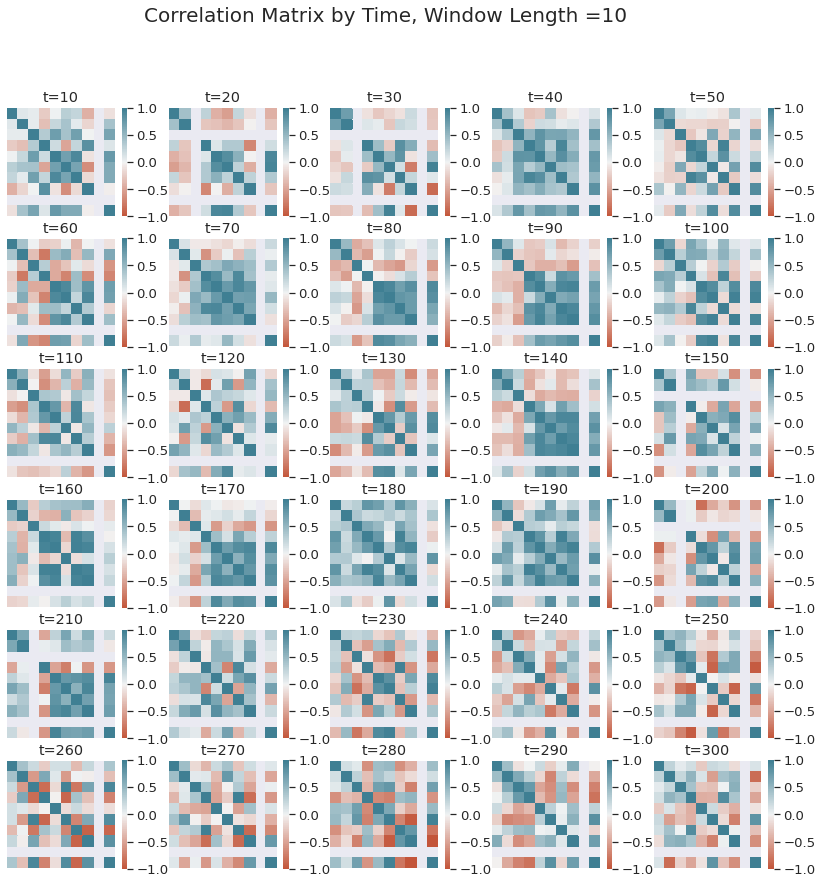

time: 19.7 s (started: 2021-01-19 15:33:01 +00:00)


In [ ]:
fig = plt.figure(figsize=[14,14])
fig.suptitle('Correlation Matrix by Time, Window Length =10', fontsize=20)

multiplier =10
ax1=fig.add_subplot(6,5,1)
ax2=fig.add_subplot(6,5,2)
ax3=fig.add_subplot(6,5,3)
ax4=fig.add_subplot(6,5,4)
ax5=fig.add_subplot(6,5,5)
ax6=fig.add_subplot(6,5,6)
ax7=fig.add_subplot(6,5,7)
ax8=fig.add_subplot(6,5,8)
ax9=fig.add_subplot(6,5,9)
ax10=fig.add_subplot(6,5,10)
ax11=fig.add_subplot(6,5,11)
ax12=fig.add_subplot(6,5,12)
ax13=fig.add_subplot(6,5,13)
ax14=fig.add_subplot(6,5,14)
ax15=fig.add_subplot(6,5,15)
ax16=fig.add_subplot(6,5,16)
ax17=fig.add_subplot(6,5,17)
ax18=fig.add_subplot(6,5,18)
ax19=fig.add_subplot(6,5,19)
ax20=fig.add_subplot(6,5,20)
ax21=fig.add_subplot(6,5,21)
ax22=fig.add_subplot(6,5,22)
ax23=fig.add_subplot(6,5,23)
ax24=fig.add_subplot(6,5,24)
ax25=fig.add_subplot(6,5,25)
ax26=fig.add_subplot(6,5,26)
ax27=fig.add_subplot(6,5,27)
ax28=fig.add_subplot(6,5,28)
ax29=fig.add_subplot(6,5,29)
ax30=fig.add_subplot(6,5,30)

sns.heatmap(np.dot(multiplier,correlation_matrices[0,10,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax1)
ax1.set_title('t=10')
sns.heatmap(np.dot(multiplier,correlation_matrices[0,20,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax2)
ax2.set_title('t=20')
sns.heatmap(np.dot(multiplier,correlation_matrices[0,30,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax3)
ax3.set_title('t=30')
sns.heatmap(np.dot(multiplier,correlation_matrices[0,40,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax4)
ax4.set_title('t=40')
sns.heatmap(np.dot(multiplier,correlation_matrices[0,50,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax5)
ax5.set_title('t=50')
sns.heatmap(np.dot(multiplier,correlation_matrices[0,60,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax6)
ax6.set_title('t=60')
sns.heatmap(np.dot(multiplier,correlation_matrices[0,70,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax7)
ax7.set_title('t=70')
sns.heatmap(np.dot(multiplier,correlation_matrices[0,80,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax8)
ax8.set_title('t=80')
sns.heatmap(np.dot(multiplier,correlation_matrices[0,90,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax9)
ax9.set_title('t=90')
sns.heatmap(np.dot(multiplier,correlation_matrices[0,100,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax10)
ax10.set_title('t=100')
sns.heatmap(np.dot(multiplier,correlation_matrices[0,110,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax11)
ax11.set_title('t=110')
sns.heatmap(np.dot(multiplier,correlation_matrices[0,120,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax12)
ax12.set_title('t=120')
sns.heatmap(np.dot(multiplier,correlation_matrices[0,130,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax13)
ax13.set_title('t=130')
sns.heatmap(np.dot(multiplier,correlation_matrices[0,140,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax14)
ax14.set_title('t=140')
sns.heatmap(np.dot(multiplier,correlation_matrices[0,150,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax15)
ax15.set_title('t=150')
sns.heatmap(np.dot(multiplier,correlation_matrices[0,160,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200),xticklabels=False, yticklabels=False,square=True, ax=ax16)
ax16.set_title('t=160')
sns.heatmap(np.dot(multiplier,correlation_matrices[0,170,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax17)
ax17.set_title('t=170')
sns.heatmap(np.dot(multiplier,correlation_matrices[0,180,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax18)
ax18.set_title('t=180')
sns.heatmap(np.dot(multiplier,correlation_matrices[0,190,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax19)
ax19.set_title('t=190')
sns.heatmap(np.dot(multiplier,correlation_matrices[0,200,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax20)
ax20.set_title('t=200')
sns.heatmap(np.dot(multiplier,correlation_matrices[0,210,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax21)
ax21.set_title('t=210')
sns.heatmap(np.dot(multiplier,correlation_matrices[0,220,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax22)
ax22.set_title('t=220')
sns.heatmap(np.dot(multiplier,correlation_matrices[0,230,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax23)
ax23.set_title('t=230')
sns.heatmap(np.dot(multiplier,correlation_matrices[0,240,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax24)
ax24.set_title('t=240')
sns.heatmap(np.dot(multiplier,correlation_matrices[0,250,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax25)
ax25.set_title('t=250')
sns.heatmap(np.dot(multiplier,correlation_matrices[0,260,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax26)
ax26.set_title('t=260')
sns.heatmap(np.dot(multiplier,correlation_matrices[0,270,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax27)
ax27.set_title('t=270')
sns.heatmap(np.dot(multiplier,correlation_matrices[0,280,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax28)
ax28.set_title('t=280')
sns.heatmap(np.dot(multiplier,correlation_matrices[0,290,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax29)
ax29.set_title('t=290')
sns.heatmap(np.dot(multiplier,correlation_matrices[0,300,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200),xticklabels=False, yticklabels=False,square=True, ax=ax30)
ax30.set_title('t=300')

plt.show()

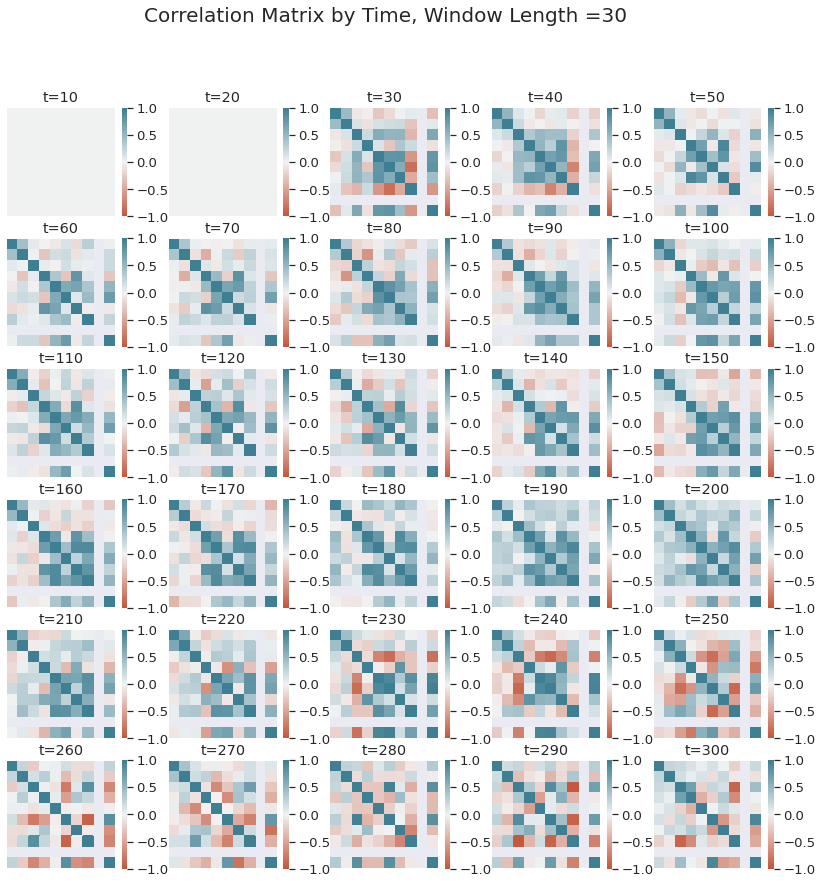

time: 20 s (started: 2021-01-19 15:35:55 +00:00)


In [ ]:
fig = plt.figure(figsize=[14,14])
fig.suptitle('Correlation Matrix by Time, Window Length =30', fontsize=20)

multiplier =30
ax1=fig.add_subplot(6,5,1)
ax2=fig.add_subplot(6,5,2)
ax3=fig.add_subplot(6,5,3)
ax4=fig.add_subplot(6,5,4)
ax5=fig.add_subplot(6,5,5)
ax6=fig.add_subplot(6,5,6)
ax7=fig.add_subplot(6,5,7)
ax8=fig.add_subplot(6,5,8)
ax9=fig.add_subplot(6,5,9)
ax10=fig.add_subplot(6,5,10)
ax11=fig.add_subplot(6,5,11)
ax12=fig.add_subplot(6,5,12)
ax13=fig.add_subplot(6,5,13)
ax14=fig.add_subplot(6,5,14)
ax15=fig.add_subplot(6,5,15)
ax16=fig.add_subplot(6,5,16)
ax17=fig.add_subplot(6,5,17)
ax18=fig.add_subplot(6,5,18)
ax19=fig.add_subplot(6,5,19)
ax20=fig.add_subplot(6,5,20)
ax21=fig.add_subplot(6,5,21)
ax22=fig.add_subplot(6,5,22)
ax23=fig.add_subplot(6,5,23)
ax24=fig.add_subplot(6,5,24)
ax25=fig.add_subplot(6,5,25)
ax26=fig.add_subplot(6,5,26)
ax27=fig.add_subplot(6,5,27)
ax28=fig.add_subplot(6,5,28)
ax29=fig.add_subplot(6,5,29)
ax30=fig.add_subplot(6,5,30)

sns.heatmap(np.dot(multiplier,correlation_matrices[1,10,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax1)
ax1.set_title('t=10')
sns.heatmap(np.dot(multiplier,correlation_matrices[1,20,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax2)
ax2.set_title('t=20')
sns.heatmap(np.dot(multiplier,correlation_matrices[1,30,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax3)
ax3.set_title('t=30')
sns.heatmap(np.dot(multiplier,correlation_matrices[1,40,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax4)
ax4.set_title('t=40')
sns.heatmap(np.dot(multiplier,correlation_matrices[1,50,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax5)
ax5.set_title('t=50')
sns.heatmap(np.dot(multiplier,correlation_matrices[1,60,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax6)
ax6.set_title('t=60')
sns.heatmap(np.dot(multiplier,correlation_matrices[1,70,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax7)
ax7.set_title('t=70')
sns.heatmap(np.dot(multiplier,correlation_matrices[1,80,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax8)
ax8.set_title('t=80')
sns.heatmap(np.dot(multiplier,correlation_matrices[1,90,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax9)
ax9.set_title('t=90')
sns.heatmap(np.dot(multiplier,correlation_matrices[1,100,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax10)
ax10.set_title('t=100')
sns.heatmap(np.dot(multiplier,correlation_matrices[1,110,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax11)
ax11.set_title('t=110')
sns.heatmap(np.dot(multiplier,correlation_matrices[1,120,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax12)
ax12.set_title('t=120')
sns.heatmap(np.dot(multiplier,correlation_matrices[1,130,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax13)
ax13.set_title('t=130')
sns.heatmap(np.dot(multiplier,correlation_matrices[1,140,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax14)
ax14.set_title('t=140')
sns.heatmap(np.dot(multiplier,correlation_matrices[1,150,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax15)
ax15.set_title('t=150')
sns.heatmap(np.dot(multiplier,correlation_matrices[1,160,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200),xticklabels=False, yticklabels=False,square=True, ax=ax16)
ax16.set_title('t=160')
sns.heatmap(np.dot(multiplier,correlation_matrices[1,170,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax17)
ax17.set_title('t=170')
sns.heatmap(np.dot(multiplier,correlation_matrices[1,180,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax18)
ax18.set_title('t=180')
sns.heatmap(np.dot(multiplier,correlation_matrices[1,190,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax19)
ax19.set_title('t=190')
sns.heatmap(np.dot(multiplier,correlation_matrices[1,200,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax20)
ax20.set_title('t=200')
sns.heatmap(np.dot(multiplier,correlation_matrices[1,210,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax21)
ax21.set_title('t=210')
sns.heatmap(np.dot(multiplier,correlation_matrices[1,220,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax22)
ax22.set_title('t=220')
sns.heatmap(np.dot(multiplier,correlation_matrices[1,230,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax23)
ax23.set_title('t=230')
sns.heatmap(np.dot(multiplier,correlation_matrices[1,240,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax24)
ax24.set_title('t=240')
sns.heatmap(np.dot(multiplier,correlation_matrices[1,250,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax25)
ax25.set_title('t=250')
sns.heatmap(np.dot(multiplier,correlation_matrices[1,260,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax26)
ax26.set_title('t=260')
sns.heatmap(np.dot(multiplier,correlation_matrices[1,270,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax27)
ax27.set_title('t=270')
sns.heatmap(np.dot(multiplier,correlation_matrices[1,280,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax28)
ax28.set_title('t=280')
sns.heatmap(np.dot(multiplier,correlation_matrices[1,290,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax29)
ax29.set_title('t=290')
sns.heatmap(np.dot(multiplier,correlation_matrices[1,300,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200),xticklabels=False, yticklabels=False,square=True, ax=ax30)
ax30.set_title('t=300')

plt.show()

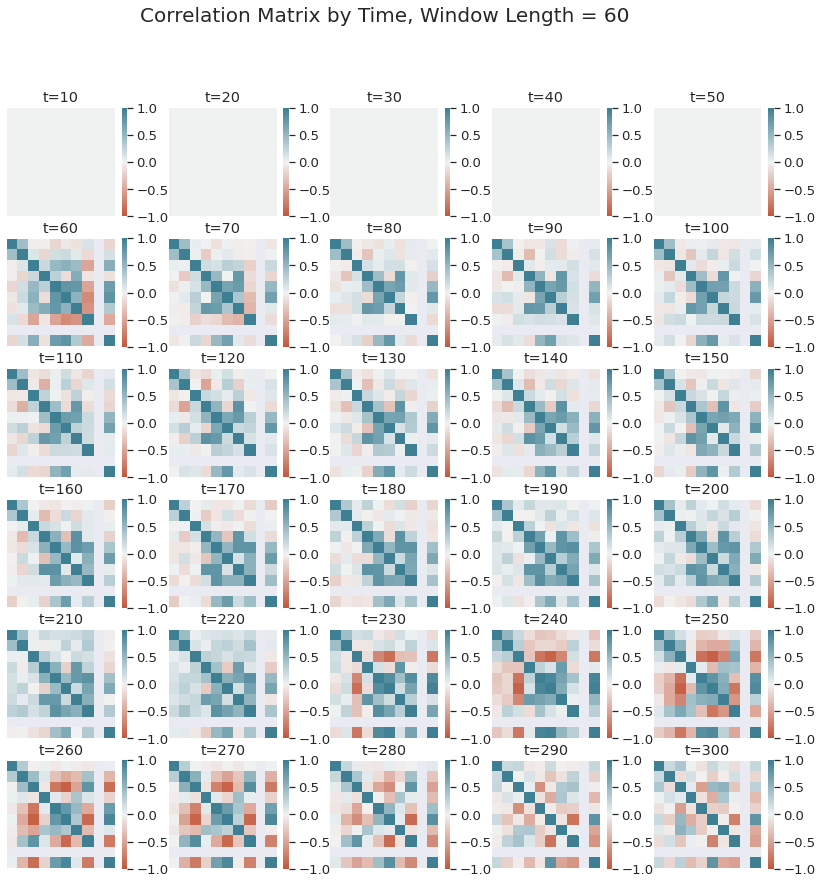

time: 19.8 s (started: 2021-01-19 15:40:06 +00:00)


In [ ]:
fig = plt.figure(figsize=[14,14])
fig.suptitle('Correlation Matrix by Time, Window Length = 60', fontsize=20)

multiplier =60
ax1=fig.add_subplot(6,5,1)
ax2=fig.add_subplot(6,5,2)
ax3=fig.add_subplot(6,5,3)
ax4=fig.add_subplot(6,5,4)
ax5=fig.add_subplot(6,5,5)
ax6=fig.add_subplot(6,5,6)
ax7=fig.add_subplot(6,5,7)
ax8=fig.add_subplot(6,5,8)
ax9=fig.add_subplot(6,5,9)
ax10=fig.add_subplot(6,5,10)
ax11=fig.add_subplot(6,5,11)
ax12=fig.add_subplot(6,5,12)
ax13=fig.add_subplot(6,5,13)
ax14=fig.add_subplot(6,5,14)
ax15=fig.add_subplot(6,5,15)
ax16=fig.add_subplot(6,5,16)
ax17=fig.add_subplot(6,5,17)
ax18=fig.add_subplot(6,5,18)
ax19=fig.add_subplot(6,5,19)
ax20=fig.add_subplot(6,5,20)
ax21=fig.add_subplot(6,5,21)
ax22=fig.add_subplot(6,5,22)
ax23=fig.add_subplot(6,5,23)
ax24=fig.add_subplot(6,5,24)
ax25=fig.add_subplot(6,5,25)
ax26=fig.add_subplot(6,5,26)
ax27=fig.add_subplot(6,5,27)
ax28=fig.add_subplot(6,5,28)
ax29=fig.add_subplot(6,5,29)
ax30=fig.add_subplot(6,5,30)

sns.heatmap(np.dot(multiplier,correlation_matrices[2,10,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax1)
ax1.set_title('t=10')
sns.heatmap(np.dot(multiplier,correlation_matrices[2,20,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax2)
ax2.set_title('t=20')
sns.heatmap(np.dot(multiplier,correlation_matrices[2,30,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax3)
ax3.set_title('t=30')
sns.heatmap(np.dot(multiplier,correlation_matrices[2,40,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax4)
ax4.set_title('t=40')
sns.heatmap(np.dot(multiplier,correlation_matrices[2,50,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax5)
ax5.set_title('t=50')
sns.heatmap(np.dot(multiplier,correlation_matrices[2,60,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax6)
ax6.set_title('t=60')
sns.heatmap(np.dot(multiplier,correlation_matrices[2,70,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax7)
ax7.set_title('t=70')
sns.heatmap(np.dot(multiplier,correlation_matrices[2,80,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax8)
ax8.set_title('t=80')
sns.heatmap(np.dot(multiplier,correlation_matrices[2,90,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax9)
ax9.set_title('t=90')
sns.heatmap(np.dot(multiplier,correlation_matrices[2,100,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax10)
ax10.set_title('t=100')
sns.heatmap(np.dot(multiplier,correlation_matrices[2,110,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax11)
ax11.set_title('t=110')
sns.heatmap(np.dot(multiplier,correlation_matrices[2,120,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax12)
ax12.set_title('t=120')
sns.heatmap(np.dot(multiplier,correlation_matrices[2,130,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax13)
ax13.set_title('t=130')
sns.heatmap(np.dot(multiplier,correlation_matrices[2,140,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax14)
ax14.set_title('t=140')
sns.heatmap(np.dot(multiplier,correlation_matrices[2,150,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax15)
ax15.set_title('t=150')
sns.heatmap(np.dot(multiplier,correlation_matrices[2,160,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200),xticklabels=False, yticklabels=False,square=True, ax=ax16)
ax16.set_title('t=160')
sns.heatmap(np.dot(multiplier,correlation_matrices[2,170,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax17)
ax17.set_title('t=170')
sns.heatmap(np.dot(multiplier,correlation_matrices[2,180,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax18)
ax18.set_title('t=180')
sns.heatmap(np.dot(multiplier,correlation_matrices[2,190,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax19)
ax19.set_title('t=190')
sns.heatmap(np.dot(multiplier,correlation_matrices[2,200,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax20)
ax20.set_title('t=200')
sns.heatmap(np.dot(multiplier,correlation_matrices[2,210,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax21)
ax21.set_title('t=210')
sns.heatmap(np.dot(multiplier,correlation_matrices[2,220,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax22)
ax22.set_title('t=220')
sns.heatmap(np.dot(multiplier,correlation_matrices[2,230,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax23)
ax23.set_title('t=230')
sns.heatmap(np.dot(multiplier,correlation_matrices[2,240,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax24)
ax24.set_title('t=240')
sns.heatmap(np.dot(multiplier,correlation_matrices[2,250,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax25)
ax25.set_title('t=250')
sns.heatmap(np.dot(multiplier,correlation_matrices[2,260,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax26)
ax26.set_title('t=260')
sns.heatmap(np.dot(multiplier,correlation_matrices[2,270,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax27)
ax27.set_title('t=270')
sns.heatmap(np.dot(multiplier,correlation_matrices[2,280,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax28)
ax28.set_title('t=280')
sns.heatmap(np.dot(multiplier,correlation_matrices[2,290,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200), xticklabels=False, yticklabels=False,square=True,ax=ax29)
ax29.set_title('t=290')
sns.heatmap(np.dot(multiplier,correlation_matrices[2,300,:,:]),vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20,220,n=200),xticklabels=False, yticklabels=False,square=True, ax=ax30)
ax30.set_title('t=300')

plt.show()

In [ ]:
def cnn_encoder_layer(data, filter_layer, strides):

    result = tf.nn.conv2d(
        input=data,
        filter=filter_layer,
        strides=strides,
        padding="SAME")
    return tf.nn.selu(result)


def tensor_variable(shape, name):
    """
    Tensor variable declaration initialization
    :param shape:
    :param name:
    :return:
    """
    variable = tf.Variable(tf.zeros(shape), name=name)
    variable = tf.compat.v1.get_variable(name, shape=shape, initializer=tf.contrib.layers.xavier_initializer())
    return variable


def cnn_encoder(data):
    """
    :param data: the input data size is 5 * 10 * 10 * 3
    :return:
    """
    #filter는 그대로 유지
    # the first layer,the output size is 10 * 10 * 32
    filter1 = tensor_variable([3, 3, 3, 32], "filter1")
    strides1 = (1, 1, 1, 1)
    cnn1_out = cnn_encoder_layer(data, filter1, strides1)

    # the second layer, the output size is 5 * 5 * 64
    filter2 = tensor_variable([3, 3, 32, 64], "filter2")
    strides2 = (1, 2, 2, 1)
    cnn2_out = cnn_encoder_layer(cnn1_out, filter2, strides2)

    # the third layer, the output size is 3 * 3 * 128
    filter3 = tensor_variable([2, 2, 64, 128], "filter3")
    strides3 = (1, 2, 2, 1)
    cnn3_out = cnn_encoder_layer(cnn2_out, filter3, strides3)

    return cnn1_out, cnn2_out, cnn3_out


def cnn_lstm_attention_layer(input_data, layer_number):
    """
    :param input_data:
    :param layer_number:
    :return:
    """
    convlstm_layer = tf.contrib.rnn.ConvLSTMCell(
        conv_ndims=2,
        input_shape=[input_data.shape[2], input_data.shape[3], input_data.shape[4]],
        output_channels=input_data.shape[-1],
        kernel_shape=[2, 2],
        use_bias=True,
        skip_connection=False,
        forget_bias=1.0,
        initializers=None,
        name="conv_lstm_cell" + str(layer_number))


    outputs, state = tf.nn.dynamic_rnn(convlstm_layer, input_data, dtype=input_data.dtype)

    # attention based on inner-product between feature representation of last step and other steps
    attention_w = []
    for k in range(step_max):
        attention_w.append(tf.reduce_sum(tf.multiply(outputs[0][k], outputs[0][-1])) / step_max)
    attention_w = tf.reshape(tf.nn.softmax(tf.stack(attention_w)), [1, step_max])

    outputs = tf.reshape(outputs[0], [step_max, -1])
    outputs = tf.matmul(attention_w, outputs)
    outputs = tf.reshape(outputs, [1, input_data.shape[2], input_data.shape[3], input_data.shape[4]])

    return outputs, attention_w


def cnn_decoder_layer(conv_lstm_out_c, filter, output_shape, strides):

    deconv = tf.nn.conv2d_transpose(
        value=conv_lstm_out_c,
        filter=filter,
        strides=strides,
        output_shape=output_shape,
        padding="SAME")
    deconv = tf.nn.selu(deconv)
    return deconv


def cnn_decoder(lstm1_out, lstm2_out, lstm3_out):

    d_filter3 = tensor_variable([2, 2, 64, 128], "d_filter3")
    dec3 = cnn_decoder_layer(lstm3_out, d_filter3, [1, 5, 5, 64], (1, 2, 2, 1))
    dec3_concat = tf.concat([dec3, lstm2_out], axis=3)

    d_filter2 = tensor_variable([3, 3, 32, 128], "d_filter2")
    dec2 = cnn_decoder_layer(dec3_concat, d_filter2, [1, 10, 10, 32], (1, 2, 2, 1))
    dec2_concat = tf.concat([dec2, lstm1_out], axis=3)

    d_filter1 = tensor_variable([3, 3, 3, 64], "d_filter1")
    dec1 = cnn_decoder_layer(dec2_concat, d_filter1, [1, 10, 10, 3], (1, 1, 1, 1))

    return dec1


time: 67.2 ms (started: 2021-01-19 15:44:42 +00:00)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
mse of last train data: 0.0077986997
mse of last train data: 0.620091
mse of last train data: 0.1780172
mse of last train data: 0.07009629
mse of last train data: 0.0375642
mse of last train data: 0.014845114
mse of last train data: 0.0115568135
mse of last train data: 0.00958344
mse of last train data: 0.0059438767
mse of last train data: 0.0040059336
mse of last train data: 0.0031516613
mse of last train data: 0.0024

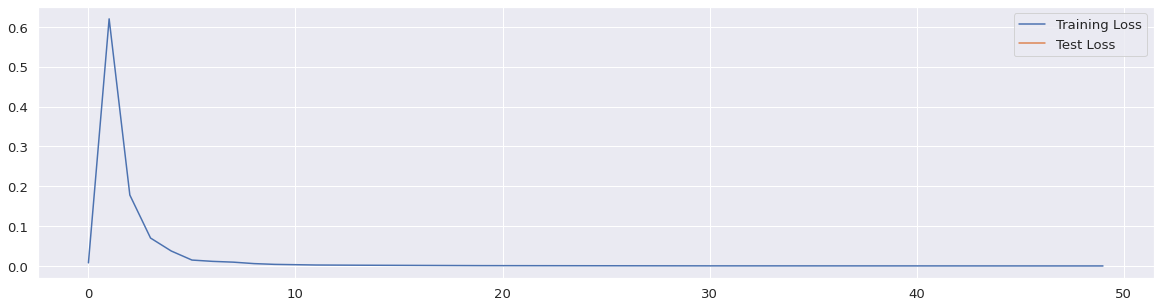

time: 23.7 s (started: 2021-01-19 00:42:06 +00:00)


In [ ]:
def main():
    # Read dataset from file
    matrix_data_path = train_data_path + "train.npy"
    matrix_gt_1 = np.load(matrix_data_path)

    sess = tf.Session()
    # data 사이즈 수정 후 수정
    data_input = tf.compat.v1.placeholder(tf.float32, [step_max, 10, 10, 3])

    # cnn encoder - 3개짜리 레이어로 수정
    conv1_out, conv2_out, conv3_out = cnn_encoder(data_input)

    conv1_out = tf.reshape(conv1_out, [-1, 5, 10, 10, 32])
    conv2_out = tf.reshape(conv2_out, [-1, 5, 5, 5, 64])
    conv3_out = tf.reshape(conv3_out, [-1, 5, 3, 3, 128])

    # lstm with attention
    conv1_lstm_attention_out, atten_weight_1 = cnn_lstm_attention_layer(conv1_out, 1)
    conv2_lstm_attention_out, atten_weight_2 = cnn_lstm_attention_layer(conv2_out, 2)
    conv3_lstm_attention_out, atten_weight_3 = cnn_lstm_attention_layer(conv3_out, 3)

    # cnn decoder
    deconv_out = cnn_decoder(conv1_lstm_attention_out, conv2_lstm_attention_out, conv3_lstm_attention_out)
    # loss function: reconstruction error of last step matrix
    loss = tf.reduce_mean(tf.square(data_input[-1] - deconv_out))
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

    # variable initialization
    init = tf.global_variables_initializer()
    sess.run(init)

    training_loss =[] 
    test_loss =[] 
    # training
    for idx in range(train_start_id, train_end_id):
        matrix_gt = matrix_gt_1[idx - train_start_id]
        feed_dict = {data_input: np.asarray(matrix_gt)}
        a, loss_value = sess.run([optimizer, loss], feed_dict)
        training_loss.append(loss_value)
        print("mse of last train data: " + str(loss_value))
    

    # test
    # Read the data from test file.
    matrix_data_path = test_data_path + "test.npy"
    matrix_gt_1 = np.load(matrix_data_path)
    result_all = []
    for idx in range(test_start_id, test_end_id):
        matrix_gt = matrix_gt_1[idx - test_start_id]
        feed_dict = {data_input: np.asarray(matrix_gt)}
        result, loss_value = sess.run([deconv_out, loss], feed_dict)
        result_all.append(result)
        test_loss.append(loss_value)
        print("mse of last test data: " + str(loss_value))

    plt.subplots(figsize=(20,5))
    plt.plot(training_loss, label="Training Loss")
    plt.plot(test_loss, label="Test Loss")
    plt.legend()

    # Write the reconstructed matrix to the file
    reconstructed_path = reconstructed_data_path
    if not os.path.exists(reconstructed_path):
        os.makedirs(reconstructed_path)
    reconstructed_path = reconstructed_path + "test_reconstructed.npy"

  #reshape
    result_all = np.asarray(result_all).reshape((-1, 10, 10, 3))
    print(result_all.shape)
    np.save(reconstructed_path, result_all)


if __name__ == '__main__':
    main()

In [ ]:
# score initialization
valid_anomaly_score = np.zeros((valid_end_id - valid_start_id, 1))
test_anomaly_score = np.zeros((test_end_id - valid_end_id, 1))

# load the data from file
test_data_path = test_data_path
reconstructed_data_path = reconstructed_data_path
test_data_path = os.path.join(test_data_path, "test.npy")
reconstructed_data_path = os.path.join(reconstructed_data_path, "test_reconstructed.npy")
test_data = np.load(test_data_path)
test_data = test_data[:, -1, ...]  # only compare the last matrix with the reconstructed data
reconstructed_data = np.load(reconstructed_data_path)
print("The shape of test data is {}".format(test_data.shape))
print("The shape of reconstructed data is {}".format(reconstructed_data.shape))

valid_len = valid_end_id - valid_start_id

# compute the threshold, threshold = alpha * max{s(t)} , s(t) is the anomaly scores over validation period.
for i in range(valid_end_id - valid_start_id):
	error = np.square(np.subtract(test_data[i, ..., 0], reconstructed_data[i, ..., 0]))
	num_anom = len(np.where(error >threhold))
	valid_anomaly_score[i] = num_anom

max_valid_anom = np.max(valid_anomaly_score)
threshold = max_valid_anom * alpha

print("Max valid anom is %.2f" % max_valid_anom)
print("Threshold is %.2f" % threshold)

# compute the anomaly score in the test data.
for i in range(test_end_id - valid_end_id):
	error = np.square(np.subtract(test_data[i, ..., 0], reconstructed_data[i, ..., 0]))
	num_anom = len(np.where(error > threshold))
	test_anomaly_score[i - valid_len] = num_anom

# plot anomaly score curve and identification result
anomaly_pos = np.zeros(5)
root_cause_gt = np.zeros((5, 3))
anomaly_span = [10, 30, 90]

# Read the test_anomaly.csv, each line behalf of an anomaly, the first is the position, the next three number is the
# root cause.
root_cause_f = open("../content/data/test_anomaly.csv", "r")

root_cause_gt = np.loadtxt(root_cause_f, delimiter=",", dtype=np.int32)
anomaly_pos = root_cause_gt[:, 0]
anomaly_pos = [(anomaly_pos[i]/gap_time-test_start_id-anomaly_span[i % 3]/gap_time) for i in range(5)]
for i in range(5):
	root_cause_gt[i][0] = anomaly_pos[i]


fig, axes = plt.subplots(figsize=(20,5))
test_num = test_end_id - test_start_id
plt.xticks(fontsize = 25)
plt.ylim((0, 100))
plt.yticks(np.arange(0, 101, 20), fontsize = 25)
plt.plot(test_anomaly_score, 'b', linewidth = 2)
threshold = np.full((test_num), max_valid_anom * alpha)
axes.plot(threshold, color = 'black', linestyle = '--',linewidth = 2)
for k in range(len(anomaly_pos)):
	axes.axvspan(anomaly_pos[k], anomaly_pos[k] + anomaly_span[k%3]/gap_time, color='red', linewidth=2)

labels = [' ', '0e3', '2e3', '4e3', '6e3', '8e3', '10e3']
axes.set_xticklabels(labels, rotation = 25, fontsize = 20)
plt.xlabel('Test Time', fontsize = 25)
plt.ylabel('Anomaly Score', fontsize = 25)
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.yaxis.set_ticks_position('left')
axes.xaxis.set_ticks_position('bottom')
fig.subplots_adjust(bottom=0.25)
fig.subplots_adjust(left=0.25)
plt.title("MSCRED", size = 25)
plt.show()

ValueError: ignored

time: 87.9 ms (started: 2021-01-19 00:42:53 +00:00)
